# Rebinning ty_trans to ty_trans_rho density levels

### For the purpose of decomposing meridional overturning streamfunction into mean and eddy components

Using density coordinate binning method of Lee et al. (2007). I modified the binning code from code written by Adele Morrison.

In [1]:
%matplotlib inline

import cosima_cookbook as cc
from cosima_cookbook import distributed as ccd
import matplotlib.pyplot as plt
import numpy as np
import netCDF4 as nc
import xarray as xr
import glob
import cmocean.cm as cmocean
from gsw import SA_from_SP, p_from_z, sigma1, CT_from_t, sigma0, sigma4
import xgcm
import logging
logging.captureWarnings(True)
logging.getLogger('py.warnings').setLevel(logging.ERROR)
import cartopy.crs as ccrs

from dask.distributed import Client

In [2]:
client = Client()
client

distributed.diskutils - INFO - Found stale lock file and directory '/g/data/x77/cy8964/Honours/energy/dask-worker-space/worker-bxrg0hiw', purging
distributed.diskutils - INFO - Found stale lock file and directory '/g/data/x77/cy8964/Honours/energy/dask-worker-space/worker-1qych_w9', purging
distributed.diskutils - INFO - Found stale lock file and directory '/g/data/x77/cy8964/Honours/energy/dask-worker-space/worker-atk0n0n_', purging
distributed.diskutils - INFO - Found stale lock file and directory '/g/data/x77/cy8964/Honours/energy/dask-worker-space/worker-9c2uug1b', purging
/g/data/hh5/public/apps/miniconda3/envs/analysis3-21.10/lib/python3.9/contextlib.py:126: UserWarning: Creating scratch directories is taking a surprisingly long time. This is often due to running workers on a network file system. Consider specifying a local-directory to point workers to write scratch data to a local disk.
  next(self.gen)


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 8
Total threads: 48,Total memory: 188.57 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:34549,Workers: 8
Dashboard: /proxy/8787/status,Total threads: 48
Started: Just now,Total memory: 188.57 GiB
Comm: tcp://127.0.0.1:46167,Total threads: 6
Dashboard: /proxy/46161/status,Memory: 23.57 GiB
Nanny: tcp://127.0.0.1:42597,


In [3]:
session = cc.database.create_session('/g/data/ik11/databases/cosima_master.db')
expt = '01deg_jra55v13_ryf9091'

# reference density value:
rho_0 = 1035.0
g = 9.81

### Load presaved 10 year time mean of ty_trans, ty_trans_rho and pot_rho_2

years 2170 to 2179 in RYF

In [7]:
ty_trans = xr.open_dataset('/g/data/x77/cy8964/Post_Process/New_SO/salttempvhrho_10yr_unweightedmonth.nc').ty_trans

In [8]:
pot_rho_2 = xr.open_dataset('/g/data/x77/cy8964/Post_Process/New_SO/pot_rho_2_10yr.nc').pot_rho_2


In [9]:
ty_trans_rho = xr.open_dataset('/g/data/x77/cy8964/Post_Process/New_SO/ty_trans_rho_10yr.nc').ty_trans_rho


### Bin ty_trans (mean Eulerian overturning) into rho bins

This uses the method of Lee et al. (2007) [Lee, M., Nurser, A., Coward, A., and De Cuevas, B. (2007). Eddy advective and diffusive
transports of heat and salt in the Southern Ocean. Journal of Physical Oceanography,
37(5):1376–1393.]

Description from my thesis: Firstly, cells in the model output with a density $\rho$ between two prescribed densities ($\rho_\text{heavy} >\rho> \rho_\text{light}$) are selected. Each cell is assigned a proximity to the lighter density $\rho_\text{light}$, which is the `bin fraction' $f_b = \frac{\rho_\text{heavy}-\rho}{\rho_\text{heavy}-\rho_\text{light}}$. Here, a bin fraction of 1 means the cell density $\rho = \rho_\text{light}$ and $f_b=0$ means $\rho = \rho_\text{heavy}$. The quantity being binned, such as the meridional transport $vh$, is then multiplied by $f_b$ and added to the lighter density $\rho_\text{light}$ bin's meridional transport, followed by the $vh(1-f_b)$ being added to the heavier bin, $\rho_\text{heavy}$. This process is repeated for all sets of consecutive bins, meaning that density bins have input from model output cells with density slightly lower and higher than it. 

In [10]:
# interpolate ty_trans to where pot_rho_2 is
ty_trans = ty_trans.interp({'yu_ocean':pot_rho_2.yt_ocean})

In [11]:
# choose bins (in this case, default ty_trans_rho pot_rho_2 bins
rho2_bins = ty_trans_rho.potrho.values
# set up a zero array to be filled in by the algorithm
ty_trans_binned = np.zeros((len(rho2_bins),len(pot_rho_2.yt_ocean),len(pot_rho_2.xt_ocean)))

In [13]:
%%time
# loop over the bins, performing Lee et al. (2007) algorithm

for i in range(len(rho2_bins)-1):
    print(i)
    bin_mask = pot_rho_2.where(pot_rho_2<=rho2_bins[i+1]).where(pot_rho_2>rho2_bins[i])*0+1
    bin_fractions = (rho2_bins[i+1]-pot_rho_2 * bin_mask)/(rho2_bins[i+1]-rho2_bins[i])
    ## bin ty_trans:
    ty_trans_in_lower_bin = (ty_trans * bin_mask * bin_fractions).sum(dim = 'st_ocean')
    ty_trans_binned[i,:,:] += ty_trans_in_lower_bin.fillna(0).values
    del ty_trans_in_lower_bin
    ty_trans_in_upper_bin = (ty_trans * bin_mask * (1-bin_fractions)).sum(dim = 'st_ocean')
    ty_trans_binned[i+1,:,:] += ty_trans_in_upper_bin.fillna(0).values
    del ty_trans_in_upper_bin

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
CPU times: user 16min 40s, sys: 14min 10s, total: 30min 51s
Wall time: 29min 4s


In [16]:
# turn np array into xarray
ty_trans_binned_array = xr.DataArray(ty_trans_binned, 
                                               coords = [rho2_bins, pot_rho_2.yt_ocean,pot_rho_2.xt_ocean], 
                                               dims = ['potrho', 'yt_ocean','xt_ocean'], 
                                               name = 'ty_trans_binned')


In [14]:
# save file

# save_dir = '/g/data/x77/cy8964/Post_Process/New_SO/'

# ds_vol_trans_across_contour_binned = xr.Dataset({'ty_trans_binned': ty_trans_binned})
# ds_vol_trans_across_contour_binned.to_netcdf(save_dir+'ty_trans_eulerian_rho_10yr.nc')


In [19]:
# interpolate to ty_trans_rho grid
ty_trans_binned_array = ty_trans_binned_array.interp({'yt_ocean':ty_trans_rho.grid_yu_ocean,'xt_ocean':ty_trans_rho.grid_xt_ocean})

In [20]:
def cumsum_from_bottom (residual):
    cumsum= (residual.cumsum('potrho')-residual.sum('potrho'))
    return cumsum
psi_avg = cumsum_from_bottom(ty_trans_rho.sum('grid_xt_ocean'))
psi_avg_mean = cumsum_from_bottom(ty_trans_binned_array.sum('grid_xt_ocean'))


#### Plot ty_trans_rho, binned ty_trans ("mean" component) and eddy (as a residual)

Text(0.5, 1.0, 'Eddy')

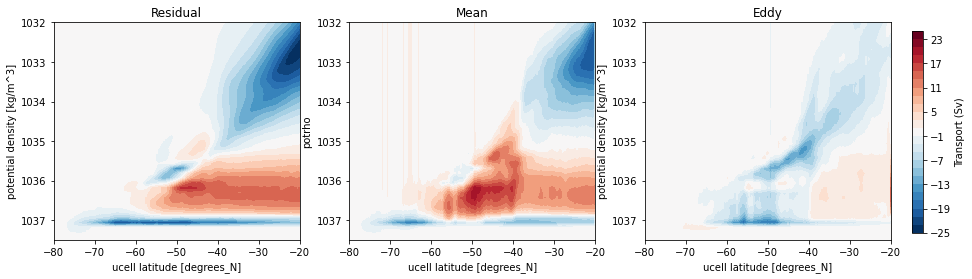

In [23]:
fig, axes = plt.subplots(nrows = 1, ncols = 3, figsize = (15,4))
levels = np.arange(-25,26,2)
(psi_avg).plot.contourf(ax = axes[0], levels = levels, add_colorbar = False)
(psi_avg_mean/1e6/rho_0).plot.contourf(ax = axes[1], levels = levels, add_colorbar = False)
p1 = (psi_avg-psi_avg_mean/1e6/rho_0).plot.contourf(ax = axes[2], levels = levels, add_colorbar = False)
cbar_ax = fig.add_axes([0.92, 0.15, 0.01, 0.7])
fig.colorbar(p1, cax=cbar_ax)
cbar_ax.set_ylabel('Transport (Sv)')

axes[0].set_ylim(1037.5,1032)
axes[1].set_ylim(1037.5,1032)
axes[2].set_ylim(1037.5,1032)
axes[0].set_xlim(-80,-20)
axes[1].set_xlim(-80,-20)
axes[2].set_xlim(-80,-20)

axes[0].set_title('Residual')
axes[1].set_title('Mean')
axes[2].set_title('Eddy')